In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('Wind_Data.csv')
data.head()


,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


In [2]:
def daily_dif(current_wind, previous_wind):
    # Calcular el incremento como la diferencia entre los vientos
    return (current_wind - previous_wind)

# Calcular incremento diario
data['wind_increase'] = daily_dif(data['regional wind'], data['regional wind'].shift(1))
data.head()


,dia,regional wind,wind gap norte sur,wind_increase
0,1,8.000000,0.000000,NaN
1,2,8.346296,0.181523,0.346296
2,3,10.062316,0.188643,1.716019
3,4,10.791337,0.071085,0.729021
4,5,10.754093,0.078442,-0.037244


In [3]:
# Definir delta
delta = 1/365

# Definir la θ(t)
def theta(i):
    return 6 + 2 * math.cos(2*math.pi * (i-1)/365)

# Calcular θ(t) para cada día
data['theta'] = data['dia'].apply(theta)
data.head()


,dia,regional wind,wind gap norte sur,wind_increase,theta
0,1,8.000000,0.000000,NaN,8.000000
1,2,8.346296,0.181523,0.346296,7.999704
2,3,10.062316,0.188643,1.716019,7.998815
3,4,10.791337,0.071085,0.729021,7.997334
4,5,10.754093,0.078442,-0.037244,7.995261


In [4]:
s_i = data['regional wind'].shift(1)
theta = data['theta']
X = ((theta - s_i) * delta)[1:].values
Y = (data['wind_increase'])[1:].values

# Modelo de regresión lineal
reg = LinearRegression().fit(X.reshape(-1, 1), Y)

# Predicciones y error
Y_pred = reg.predict(X.reshape(-1, 1))
error = Y - Y_pred

# Cálculo de kappa y sigma con error de estimación
kappa = reg.coef_[0]
c = np.sqrt(error.var())
sigma = c / np.sqrt(delta)

# Error estándar de σ
sigma_error = sigma / np.sqrt(2 * len(error))

# Error estándar de kappa
kappa_error = np.sqrt(np.sum((error - np.mean(error))**2) / (len(error) - 2)) / np.sqrt(np.sum(X**2))

print(f"κ: {kappa}, Error de κ: {kappa_error}")
print(f"σ: {sigma}, Error de σ: {sigma_error}")



κ: 109.04125628331572, Error de κ: 4.294413913397189
σ: 16.04457314539312, Error de σ: 0.18781325432638485


In [5]:
# Creamos 'gap_dif' como la diferencia diaria del gap del viento entre el norte y sur
data['gap_dif'] = data['wind gap norte sur'] - data['wind gap norte sur'].shift(1)
data.head()

# Definimos variables para wind gap
Y_gap = (data['gap_dif'])[1:].values
d_i = data['wind gap norte sur'].shift(1)
X_gap = (d_i * delta)[1:].values

# Ajustar el modelo de regresión lineal para el wind gap
reg_gap = LinearRegression().fit(X_gap.reshape(-1, 1), Y_gap)

# Predecimos y calculamos error
Y_pred_gap = reg_gap.predict(X_gap.reshape(-1, 1))
error_gap = Y_gap - Y_pred_gap

# Cálculo de beta y gamma y su error de estimación
beta = -(reg_gap.coef_[0])
gamma = np.sqrt(error_gap.var()) / np.sqrt(delta)

# Error estándar de gamma
gamma_error = gamma / np.sqrt(len(error_gap))

# Error estándar de beta
beta_error = np.sqrt(np.sum((error_gap - np.mean(error_gap))**2) / (len(error_gap) - 2)) / np.sqrt(np.sum(X_gap**2))

print(f"β: {beta}, Error de β: {beta_error}")
print(f"γ: {gamma}, Error de γ: {gamma_error}")

β: 48.37733323194379, Error de β: 3.0057533121947224
γ: 10.090719957138331, Error de γ: 0.1670456696712918


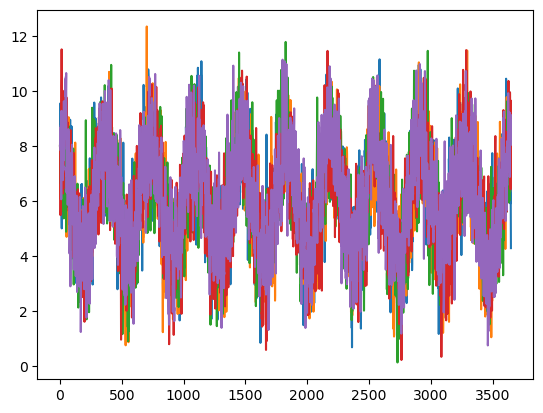

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Función para simular caminos de viento
def wind_paths(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T, M):
    S = np.full((M, T), S_0)
    D = np.full((M, T), D_0)
    for j in range (M):
        for t in range(1, T):
            Z = np.random.normal(0, 1)  # Shock para el viento regional
            W = np.random.normal(0, 1)  # Shock para la diferencia de viento
            
            # Evolución del viento regional
            S[j][t] = S[j][t-1] + kappa * (theta[t] - S[j][t-1]) * delta + np.sqrt(delta) * Z * sigma
            
            # Evolución de la diferencia de viento entre Norte y Sur
            D[j][t] = D[j][t-1] - (beta * D[j][t-1] * delta) + gamma * np.sqrt(delta) * W

    return S, D

# Inicialización de parámetros
S_0 = data['regional wind'].iloc[0]
D_0 = data['wind gap norte sur'].iloc[0]
T = len(data)  # Usamos el mismo número de días que en los datos históricos
delta = 1 / 365  
M = 5

# Simulamos
S, D = wind_paths(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T, M)

# Calculamos viento en Norte y Sur
viento_norte = S - D / 2
viento_sur = S + D / 2

#Calculamos viento historico norte y sur
viento_norte_historico = data['regional wind'] - data['wind gap norte sur'] / 2
viento_sur_historico = data['regional wind'] + data['wind gap norte sur'] / 2

for S_i in S :
  plt.plot(S_i)

plt.show()

# Graficamos el viento regional y simulado
# plt.figure(figsize=(10, 6))
# plt.plot(data['regional wind'], label='Viento Regional Histórico', color='blue')
# plt.plot(S, label='Viento Regional Simulado', color='red')
# plt.title('Comparación de Viento Regional: Histórico vs. Simulado')
# plt.xlabel('Día')
# plt.ylabel('Viento Regional')
# plt.legend()
# plt.show()

# Graficamos la diferencia de viento (gap) entre Norte y Sur
# plt.figure(figsize=(10, 6))
# plt.plot(data['wind gap norte sur'], label='Gap Viento Histórico (Norte - Sur)', color='blue')
# plt.plot(D, label='Gap Viento Simulado (Norte - Sur)', color='orange')
# plt.title('Comparación de Gap de Viento: Histórico vs. Simulado')
# plt.xlabel('Día')
# plt.ylabel('Diferencia de Viento')
# plt.legend()
# plt.show()

# Graficamos el viento en el molino Norte

# plt.figure(figsize=(10, 6))
# plt.plot(viento_norte_historico, label='Viento Norte Historico', color='red')
# plt.plot(viento_norte, label='Viento Norte Simulado', color='green')
# plt.title('Viento Simulado en el Molino Norte')
# plt.xlabel('Día')
# plt.ylabel('Viento Norte')
# plt.legend()
# plt.show()

# Graficamos el viento en el molino Sur
# plt.figure(figsize=(10, 6))
# plt.plot(viento_sur_historico, label='Viento Sur Historico', color='green')
# plt.plot(viento_sur, label='Viento Sur Simulado', color='purple')
# plt.title('Viento Simulado en el Molino Sur')
# plt.xlabel('Día')
# plt.ylabel('Viento Sur')
# plt.legend()
# plt.show()


In [10]:
np.exp(-0.05 * np.arange(T) / 365)

array([1.        , 0.99986302, 0.99972606, 0.99958913, 0.9994522 ,
       0.9993153 , 0.99917842, 0.99904156, 0.99890471, 0.99876788,
       0.99863107, 0.99849429, 0.99835751, 0.99822076, 0.99808403,
       0.99794732, 0.99781062, 0.99767394, 0.99753728, 0.99740064,
       0.99726402, 0.99712742, 0.99699084, 0.99685427, 0.99671773,
       0.9965812 , 0.99644469, 0.9963082 , 0.99617173, 0.99603528,
       0.99589884, 0.99576243, 0.99562603, 0.99548965, 0.9953533 ,
       0.99521695, 0.99508063, 0.99494433, 0.99480805, 0.99467178,
       0.99453553, 0.9943993 , 0.99426309, 0.9941269 , 0.99399073,
       0.99385458, 0.99371844, 0.99358233, 0.99344623, 0.99331015,
       0.99317409, 0.99303805, 0.99290202, 0.99276602, 0.99263003,
       0.99249406, 0.99235812, 0.99222219, 0.99208627, 0.99195038,
       0.99181451, 0.99167865, 0.99154281, 0.991407  , 0.9912712 ,
       0.99113541, 0.99099965, 0.99086391, 0.99072818, 0.99059248,
       0.99045679, 0.99032112, 0.99018547, 0.99004983, 0.98991

VAN del Molino Norte: 871441.87 USD
VAN del Molino Sur: 627213.68 USD


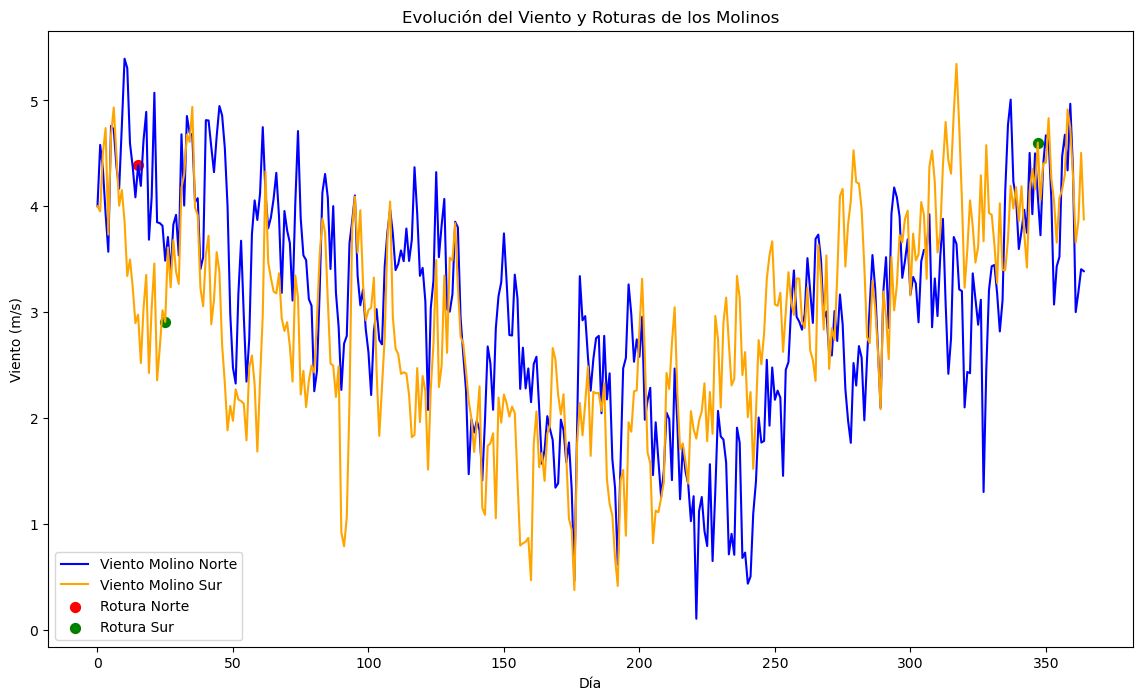

In [7]:
def simulate_molino(S, K, T, M):
    cash_flow = np.zeros(M, T)
    roturas = [[] for i in range(M)]
    
    for j in range(M):

        estado = 'apagado'
        roto = False

        for t in range(0, T):

            if estado == 'encendido':
                prob_falla = 0.25 * (S[t] ** 2) * delta
                if np.random.random() < prob_falla:
                        roto = True  # El molino se rompe
                        roturas[j].append(t)

            if roto:
                cash_flow[j,t] = -200000  # Costo de reparación
                roto = False  # Molino se repara en el mismo día
                estado = 'apagado'  # Se apaga después de repararse

            else:
                if S[t] > K and estado == 'encendido':
                    cash_flow[j,t] = -1000  # Costo de apagar
                    estado = 'apagado'

                elif S[t] <= K and estado == 'apagado':
                    cash_flow[j,t] = 0  # Encender no cuesta nada
                    estado = 'encendido'
                
                if estado == 'encendido':
                    ingreso_diario = 1000 * S[t]
                    cash_flow[j,t] = ingreso_diario
        
    return cash_flow, roturas

# Parámetros iniciales
S_0 = data['regional wind'].iloc[0]
D_0 = data['wind gap norte sur'].iloc[0]
T = 365
delta = 1 / 365

# Simulación de viento
S, D = wind_paths(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)

# Parámetros de operación
K = 7  # Umbral de velocidad de viento para apagar el molino

# Simulación de molinos Norte y Sur
cash_flow_norte, roturas_norte = simulate_molino((S - D) / 2, K, T)
cash_flow_sur, roturas_sur = simulate_molino((S + D) / 2, K, T)

# Cálculo del Valor Actual Neto (VAN)
tasa_interes = 0.05
def calcular_van(cash_flow, tasa_interes, T):
    descuento = np.exp(-tasa_interes * np.arange(T) / 365)
    VAN = np.sum(cash_flow * descuento)
    return VAN

# Resultados
VAN_norte = calcular_van(cash_flow_norte, tasa_interes, T)
VAN_sur = calcular_van(cash_flow_sur, tasa_interes, T)
print(f"VAN del Molino Norte: {VAN_norte:.2f} USD")
print(f"VAN del Molino Sur: {VAN_sur:.2f} USD")

# Gráfico de la evolución del viento con roturas
plt.figure(figsize=(14, 8))
plt.plot((S - D) / 2, label='Viento Molino Norte', color='blue')
plt.plot((S + D) / 2, label='Viento Molino Sur', color='orange')
plt.scatter(np.arange(T)[roturas_norte], ((S - D) / 2)[roturas_norte], color='red', label='Rotura Norte', s=50)
plt.scatter(np.arange(T)[roturas_sur], ((S + D) / 2)[roturas_sur], color='green', label='Rotura Sur', s=50)
plt.title('Evolución del Viento y Roturas de los Molinos')
plt.xlabel('Día')
plt.ylabel('Viento (m/s)')
plt.legend()
plt.show()


In [8]:
import numpy as np

# Parámetros
T = 365
tasa_interes = 0.05

# Función para calcular el Valor Actual Neto (VAN)
def calcular_van(cash_flow, tasa_interes, T):
    descuento = np.exp(-tasa_interes * np.arange(T) / 365)
    VAN = np.sum(cash_flow * descuento)
    return VAN

# Función para encontrar el umbral óptimo de K
def k_optimo(num_simulaciones=10000):
    vans = []  # Lista para almacenar los VAN máximos de cada simulación
    k_optimos = []  # Lista para almacenar los K óptimos de cada simulación

    for i in range(num_simulaciones):
        S, D = wind_paths(S_0, D_0, kappa, theta, sigma, delta, beta, gamma, T)
        van_max = -np.inf  # Inicializa el VAN máximo como un valor muy bajo
        k_max = None  # Inicializa el mejor K como None

        for k in range(6, 21):
            cash_flow_norte, _ = simulate_molino((S + D) / 2, k, T)
            cash_flow_sur, _ = simulate_molino((S - D) / 2, k, T)
            cash_flow_total = cash_flow_norte + cash_flow_sur

            van = calcular_van(cash_flow_total, tasa_interes, T)  # Calcula el VAN del cash flow total

            if van > van_max:  # Compara el VAN calculado con el máximo anterior
                van_max = van
                k_max = k
        
        vans.append(van_max)  # Almacena el VAN máximo de esta simulación
        k_optimos.append(k_max)  # Almacena el K óptimo de esta simulación

    # Promedio de los VANs y de los K óptimos
    van_promedio = np.mean(vans)
    k_promedio = np.mean(k_optimos)

    return k_promedio, van_promedio

# Ejecutar la función
k_promedio, van_promedio = k_optimo(num_simulaciones=10000)

# Mostrar resultados
print(f"El umbral K óptimo promedio es: {k_promedio}")
print(f"El VAN promedio es: {van_promedio:.2f} USD")


KeyboardInterrupt: 